In [55]:
import time
from datetime import datetime
from tqdm import tqdm
from typing import List, Tuple, Optional
from dataprep.eda import plot, plot_correlation, create_report, plot_missing

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
# большая чёткость графиков
#%config InlineBackend.figure_format = 'svg'
#plt.savefig("High resoltion.png",dpi=600)

import scipy.stats as st
from scipy.stats import probplot, ks_2samp

import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from catboost import Pool
from catboost.utils import get_roc_curve

from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score
from sklearn.metrics import (roc_auc_score, recall_score, accuracy_score, auc, classification_report, \
                            confusion_matrix, plot_confusion_matrix, precision_recall_curve, \
                            plot_precision_recall_curve, roc_curve, plot_roc_curve)
import copy
import missingno as msno
import shap

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
from src.processing import ColumnSelector, NumberSelector, OHEEncoder, get_num_features, get_cat_features


# from src.metrics import precision_at_k, recall_at_k
# from src.utils import prefilter_items
# from src.recommenders import MainRecommender

In [3]:
train = pd.read_csv("../../data/kaggle/gb_competitive_data_analysis/train.csv")
test = pd.read_csv("../../data/kaggle/gb_competitive_data_analysis/test.csv")
bki = pd.read_csv("../../data/kaggle/gb_competitive_data_analysis/bki.csv")
client_profile = pd.read_csv("../../data/kaggle/gb_competitive_data_analysis/client_profile.csv")
payments = pd.read_csv("../../data/kaggle/gb_competitive_data_analysis/payments.csv")
applications_history = pd.read_csv("../../data/kaggle/gb_competitive_data_analysis/applications_history.csv")

print("train.shape = {} rows, {} cols".format(*train.shape))
print("test.shape = {} rows, {} cols".format(*test.shape))
print("bki.shape = {} rows, {} cols".format(*test.shape))
print("client_profile.shape = {} rows, {} cols".format(*test.shape))
print("payments.shape = {} rows, {} cols".format(*test.shape))
print("applications_history.shape = {} rows, {} cols".format(*test.shape))

train.shape = 110093 rows, 3 cols
test.shape = 165141 rows, 2 cols
bki.shape = 165141 rows, 2 cols
client_profile.shape = 165141 rows, 2 cols
payments.shape = 165141 rows, 2 cols
applications_history.shape = 165141 rows, 2 cols


In [4]:
df_list = [train, test, bki, client_profile, payments, applications_history]

## EDA

Columns	Description
- train.csv 	| Пары "заявка - целевая переменная", для этой выборки нужно собрать признаки и обучить модель
- PPLICATION_NUMBER |	Номер заявки
- ARGET |	Целевая переменная (0 - всё ОК, 1 - проблемный клиент)
- AME_CONTRACT_TYPE |	Наличные (cash) или ушли в минуc по карте (revolving)
*****************************	
- test.csv |	Пары "заявки - прогнозное значение", для этой выборки нужно собрать признаки и построить прогнозы
- APPLICATION_NUMBER |	Номер текущей заявки
- NAME_CONTRACT_TYPE |	Наличные (cash) или ушли в минуc по карте (revolving)
*****************************	
- bki.csv |	Данные БКИ о предыдущих кредитах клиента
- APPLICATION_NUMBER |	Номер текущей заявки
- BUREAU_ID |	Зашифрованный идентификатор предыдущего кредита по версии бюро
- CREDIT_ACTIVE |	Статус кредита по информации кредитного бюро
- CREDIT_CURRENCY |	Валюта кредита
- DAYS_CREDIT |	За сколько дней до текущей заявки случился предыдущий кредит
- CREDIT_DAY_OVERDUE |	Количество дней просрочек по предыдущему кредиту
- DAYS_CREDIT_ENDDATE |	Количество дней до конца предыдущего кредита
- DAYS_ENDDATE_FACT |	Если кредит был закрыт, то сколько прошло дней
- AMT_CREDIT_MAX_OVERDUE |	Наибольшая сумма просроченного платежа по кредиту
- CNT_CREDIT_PROLONG |	Сколько раз продлевался кредит
- AMT_CREDIT_SUM |	Сумма предыдущего кредита
- AMT_CREDIT_SUM_DEBT |	Остаток долга перед банком по предыдущему кредиту
- AMT_CREDIT_SUM_LIMIT |	Лимит по кредиту (по кредитной карте)
- AMT_CREDIT_SUM_OVERDUE |	Просроченная сумма по выплате на момент заявки
- CREDIT_TYPE |	Цель кредита
- DAYS_CREDIT_UPDATE |	За сколько дней до подачи заявки поступила информация из бюро
- AMT_ANNUITY |	Сумма ежемесечного платежа при выплате равными долями
******************************	
- client_profile.csv |	Клиентский профиль, некоторые знания, которые есть у компании о клиенте
- APPLICATION_NUMBER |	Номер текущей заявки
- GENDER |	Пол клиента
- CHILDRENS |	Количество детей
- TOTAL_SALARY |	Суммарный доход
- AMOUNT_CREDIT |	Сумма кредита
- AMOUNT_ANNUITY |	Ежемесячный платёж по кредиту (основная часть + проценты)
- EDUCATION_LEVEL |	Уровень образования клиента
- FAMILY_STATUS |	Семейный статус
- REGION_POPULATION |	Уровень населенности места жительства клиента
- AGE |	Возраст в днях
- DAYS_ON_LAST_JOB |	Количество дней на последней работе
- OWN_CAR_AGE |	Возраст машины
- FLAG_PHONE |	Указал ли клиент телефон (видимо домашний)
- FLAG_EMAIL |	Указан ли адрес электронной почты
- FAMILY_SIZE |	Общее количество членов семьи
- EXTERNAL_SCORING_RATING_1 |	Какой-то кредитный рейтинг #1
- EXTERNAL_SCORING_RATING_2 |	Какой-то кредитный рейтинг #2
- EXTERNAL_SCORING_RATING_3 |	Какой-то кредитный рейтинг #3
- AMT_REQ_CREDIT_BUREAU_HOUR |	Количество запросов в бюро о клиенте за час до подачи заявки
- AMT_REQ_CREDIT_BUREAU_DAY |	Количество запросов в бюро о клиенте за день до подачи заявки (не включая последний час)
- AMT_REQ_CREDIT_BUREAU_WEEK |	Количество запросов в бюро о клиенте за неделю до подачи заявки (не включая последний день)
- AMT_REQ_CREDIT_BUREAU_MON |	Количество запросов в бюро о клиенте за месяц до подачи заявки (не включая последнюю неделю)
- AMT_REQ_CREDIT_BUREAU_QRT |	Количество запросов в бюро о клиенте за квартал до подачи заявки (не включая последний месяц)
- AMT_REQ_CREDIT_BUREAU_YEAR |	Количество запросов в бюро о клиенте за год до подачи заявки (не включая последний квартал)
******************************	
- payments.csv |	История платежей клиента
- PREV_APPLICATION_NUMBER |	Идентификатор одного из предыдущих кредитов в том же кредитном учереждении
- APPLICATION_NUMBER |	Номер текущей заявки
- NUM_INSTALMENT_VERSION |	Количество изменений в графике платежей
- NUM_INSTALMENT_NUMBER |	Номер платежа
- DAYS_INSTALMENT |	Сколько дней назад должен был быть совершен платеж
- DAYS_ENTRY_PAYMENT |	Сколько дней назад платёж был совершен
- AMT_INSTALMENT |	Величина платежа
- AMT_PAYMENT |	Сколько было оплачено
******************************	
- applications_history.csv |	История предыдущих заявок клиента
- PREV_APPLICATION_NUMBER |	Идентификатор предыдущей заявки в том же кредитном учереждении
- APPLICATION_NUMBER |	Номер текущей заявки
- NAME_CONTRACT_TYPE |	Тип кредитного продукта
- AMOUNT_ANNUITY |	Размер ежемесячного платежа
- AMT_APPLICATION |	Запрошенная сумма предыдущего кредита в заявке
- AMOUNT_CREDIT |	Размер одобренного кредита
- AMOUNT_PAYMENT |	Сумма совершенного платежа (первоначальный взнос?)
- AMOUNT_GOODS_PAYMENT |	Стоимость товара на который берется кредит
- NAME_CONTRACT_STATUS |	Решение по заявке
- DAYS_DECISION |	Сколько дней назад было принято решение
- NAME_PAYMENT_TYPE |	Способ оплаты (совершения платежей по кредиту)
- CODE_REJECT_REASON |	Причина отказа
- NAME_TYPE_SUITE |	С кем пришел клиент
- NAME_CLIENT_TYPE |	Старый или новый клиент
- NAME_GOODS_CATEGORY | Категория приобритаемого в кредит товара
- NAME_PORTFOLIO |	Вид кредитного продукта (наличные, потребительский в магазине и т.д.)
- NAME_PRODUCT_TYPE |	Клиент был вовлечен через другие продукты или сам пришел
- SELLERPLACE_AREA |	Где была совершена заявка на кредит (закодированно)
- CNT_PAYMENT |	Срок кредитования (месяцы)
- NAME_YIELD_GROUP |	Уровень процентной ставки (сгруппировано)
- DAYS_FIRST_DRAWING |	Сколько дней назад должен был быть совершен первый платёж
- DAYS_FIRST_DUE |	Сколько дней назад был совершен первый платёж
- DAYS_LAST_DUE_1ST_VERSION |	Когда должен был быть совершен последний платёж
- DAYS_LAST_DUE |	Сколько дней назад последний платеж был совершен
- DAYS_TERMINATION |	Сколько дней назад заявка была закрыта (прекращена)
- NFLAG_INSURED_ON_APPROVAL |	Был ли кредит застрахован
******************************	

### Train

In [5]:
print("train.shape = {} rows, {} cols".format(*train.shape))
train.head()

train.shape = 110093 rows, 3 cols


APPLICATION_NUMBER  TARGET NAME_CONTRACT_TYPE
0           123687442       0               Cash
1           123597908       1               Cash
2           123526683       0               Cash
3           123710391       1               Cash
4           123590329       1               Cash

In [6]:
train['NAME_CONTRACT_TYPE'].unique()

array(['Cash', 'Credit Card'], dtype=object)

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110093 entries, 0 to 110092
Data columns (total 3 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   APPLICATION_NUMBER  110093 non-null  int64 
 1   TARGET              110093 non-null  int64 
 2   NAME_CONTRACT_TYPE  110093 non-null  object
dtypes: int64(2), object(1)
memory usage: 2.5+ MB


In [8]:
train.duplicated(subset=['APPLICATION_NUMBER']).value_counts()

False    110093
dtype: int64

**train: пропусков нет, дубликатов нет**

### Test

In [9]:
print("test.shape = {} rows, {} cols".format(*test.shape))
test.head()

test.shape = 165141 rows, 2 cols


APPLICATION_NUMBER NAME_CONTRACT_TYPE
0           123724268               Cash
1           123456549               Cash
2           123428178        Credit Card
3           123619984               Cash
4           123671104               Cash

In [10]:
test['NAME_CONTRACT_TYPE'].unique()

array(['Cash', 'Credit Card'], dtype=object)

In [11]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165141 entries, 0 to 165140
Data columns (total 2 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   APPLICATION_NUMBER  165141 non-null  int64 
 1   NAME_CONTRACT_TYPE  165141 non-null  object
dtypes: int64(1), object(1)
memory usage: 2.5+ MB


In [12]:
test.duplicated(subset=['APPLICATION_NUMBER']).value_counts()

False    165141
dtype: int64

**Пропусков нет, дубликатов нет**

### BKI

In [13]:
print("bki.shape = {} rows, {} cols".format(*bki.shape))
bki.head()

bki.shape = 945234 rows, 17 cols


APPLICATION_NUMBER  BUREAU_ID CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0           123538884    5223613        Active      currency 1        718.0   
1           123436670    6207544        Closed      currency 1        696.0   
2           123589020    6326395        Closed      currency 1        165.0   
3           123494590    6606618        Active      currency 1         55.0   
4           123446603    5046832        Active      currency 1        358.0   

   CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                   0                377.0                NaN   
1                   0                511.0              511.0   
2                   0                149.0              160.0   
3                   0                310.0                NaN   
4                   0                 35.0                NaN   

   AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                19386.81                   0       675000.00   
1                    0.00                   0        93111.66   
2                     NaN                   0        36000.00   
3                     NaN                   0        38664.00   
4                     NaN                   0        67500.00   

   AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0           320265.495                   0.0                     0.0   
1                0.000                   0.0                     0.0   
2                0.000                   0.0                     0.0   
3            37858.500                   NaN                     0.0   
4                0.000                   0.0                     0.0   

       CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0  Consumer credit                39.0          NaN  
1  Consumer credit               505.0          NaN  
2  Consumer credit               150.0          0.0  
3  Consumer credit                15.0          NaN  
4      Credit card               116.0          NaN

In [14]:
bki.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 945234 entries, 0 to 945233
Data columns (total 17 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   APPLICATION_NUMBER      945234 non-null  int64  
 1   BUREAU_ID               945234 non-null  int64  
 2   CREDIT_ACTIVE           945234 non-null  object 
 3   CREDIT_CURRENCY         945234 non-null  object 
 4   DAYS_CREDIT             945234 non-null  float64
 5   CREDIT_DAY_OVERDUE      945234 non-null  int64  
 6   DAYS_CREDIT_ENDDATE     886797 non-null  float64
 7   DAYS_ENDDATE_FACT       596274 non-null  float64
 8   AMT_CREDIT_MAX_OVERDUE  326557 non-null  float64
 9   CNT_CREDIT_PROLONG      945234 non-null  int64  
 10  AMT_CREDIT_SUM          945229 non-null  float64
 11  AMT_CREDIT_SUM_DEBT     803483 non-null  float64
 12  AMT_CREDIT_SUM_LIMIT    619267 non-null  float64
 13  AMT_CREDIT_SUM_OVERDUE  945234 non-null  float64
 14  CREDIT_TYPE         

In [15]:
# получим список признаков с категорией object
bki_obj_feat = list(bki.loc[:, bki.dtypes == 'object'].columns.values)
bki_obj_feat, len(bki_obj_feat)

(['CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CREDIT_TYPE'], 3)

In [16]:
# список уникальных значений по категориальным фичам
for column in bki_obj_feat:
    print(f'{column}: {bki[column].unique()} \n')

CREDIT_ACTIVE: ['Active' 'Closed' 'Sold' 'Bad debt'] 

CREDIT_CURRENCY: ['currency 1' 'currency 2' 'currency 3' 'currency 4'] 

CREDIT_TYPE: ['Consumer credit' 'Credit card' 'Car loan' 'Mortgage'
 'Loan for business development' 'Microloan'
 'Loan for working capital replenishment' 'Unknown type of loan'
 'Loan for the purchase of equipment' 'Another type of loan'
 'Cash loan (non-earmarked)' 'Real estate loan' 'Mobile operator loan'
 'Loan for purchase of shares (margin lending)'] 



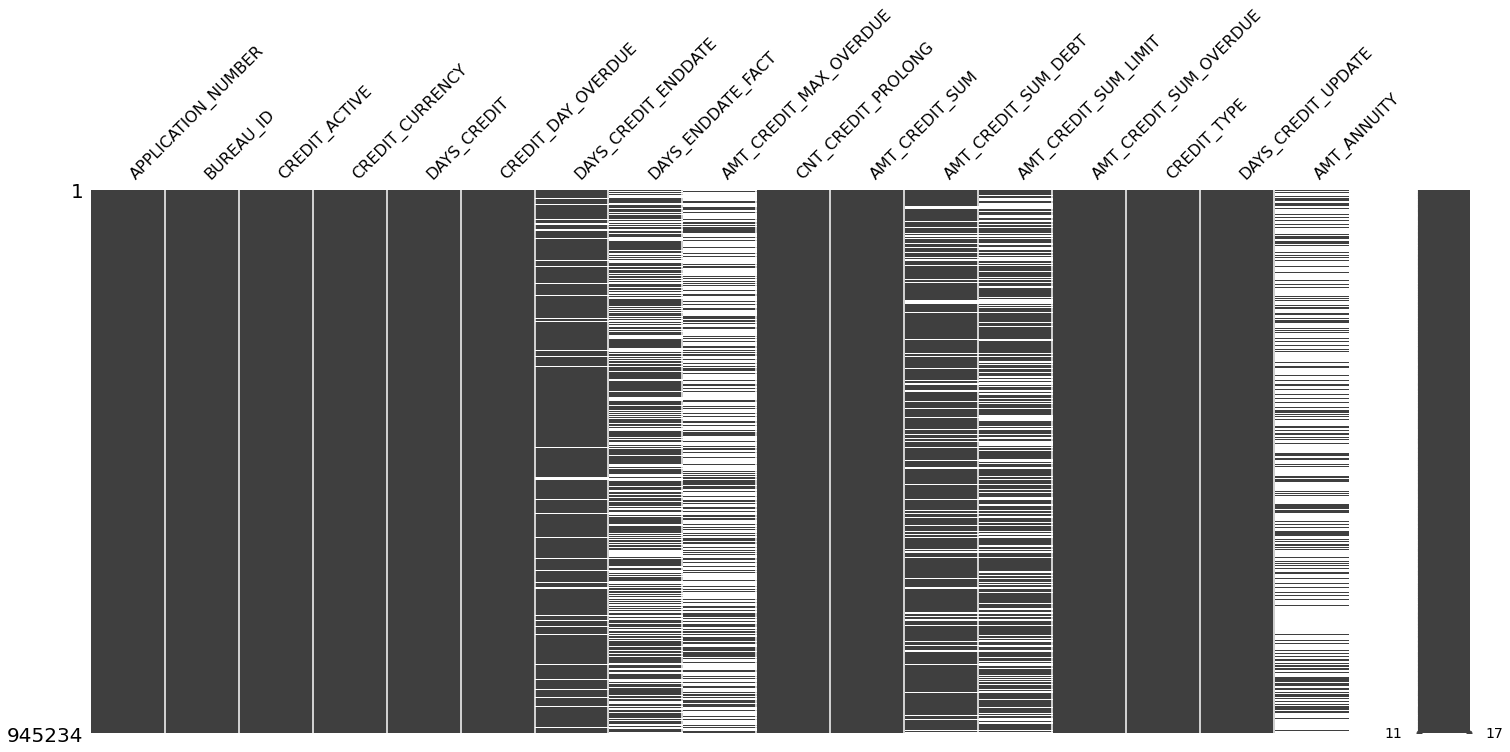

In [17]:
msno.matrix(bki);

In [18]:
bki.duplicated(subset=['APPLICATION_NUMBER']).value_counts()

True     672103
False    273131
dtype: int64

**Есть 672103 дублирующихся записей по 'APPLICATION_NUMBER'**

### client_profile

In [19]:
print("client_profile.shape = {} rows, {} cols".format(*client_profile.shape))
client_profile.head()

client_profile.shape = 250000 rows, 24 cols


APPLICATION_NUMBER GENDER  CHILDRENS  TOTAL_SALARY  AMOUNT_CREDIT  \
0           123666076      F          0      157500.0       270000.0   
1           123423688      F          0      270000.0       536917.5   
2           123501780      M          1      427500.0       239850.0   
3           123588799      M          0      112500.0       254700.0   
4           123647485      M          0      130500.0       614574.0   

   AMOUNT_ANNUITY                EDUCATION_LEVEL   FAMILY_STATUS  \
0         13500.0              Incomplete higher  Civil marriage   
1         28467.0  Secondary / secondary special         Married   
2         23850.0              Incomplete higher         Married   
3         17149.5  Secondary / secondary special         Married   
4         19822.5                Lower secondary         Married   

   REGION_POPULATION    AGE  ...  FAMILY_SIZE  EXTERNAL_SCORING_RATING_1  \
0           0.008068   8560  ...          2.0                   0.329471   
1           0.020246  23187  ...          2.0                        NaN   
2           0.072508  14387  ...          3.0                   0.409017   
3           0.019101  14273  ...          2.0                        NaN   
4           0.022625  22954  ...          2.0                        NaN   

   EXTERNAL_SCORING_RATING_2  EXTERNAL_SCORING_RATING_3  \
0                   0.236315                   0.678568   
1                   0.442295                   0.802745   
2                   0.738159                        NaN   
3                   0.308994                   0.590233   
4                   0.739408                   0.156640   

   AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         NaN                        NaN   
3                         0.0                        0.0   
4                         0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         NaN                        NaN   
3                         0.0                        0.0   
4                         1.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        1.0                         2.0  
1                        1.0                         1.0  
2                        NaN                         NaN  
3                        0.0                         3.0  
4                        0.0                         6.0  

[5 rows x 24 columns]

In [20]:
client_profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 24 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   APPLICATION_NUMBER          250000 non-null  int64  
 1   GENDER                      250000 non-null  object 
 2   CHILDRENS                   250000 non-null  int64  
 3   TOTAL_SALARY                250000 non-null  float64
 4   AMOUNT_CREDIT               250000 non-null  float64
 5   AMOUNT_ANNUITY              249989 non-null  float64
 6   EDUCATION_LEVEL             250000 non-null  object 
 7   FAMILY_STATUS               250000 non-null  object 
 8   REGION_POPULATION           250000 non-null  float64
 9   AGE                         250000 non-null  int64  
 10  DAYS_ON_LAST_JOB            250000 non-null  int64  
 11  OWN_CAR_AGE                 85041 non-null   float64
 12  FLAG_PHONE                  250000 non-null  int64  
 13  FLAG_EMAIL    

In [45]:
round(client_profile.describe(), 1)

APPLICATION_NUMBER  CHILDRENS  TOTAL_SALARY  AMOUNT_CREDIT  \
count            250000.0   250000.0      250000.0       250000.0   
mean          123577106.0        0.4      169066.2       599305.1   
std               88777.2        0.7      258848.0       402272.0   
min           123423341.0        0.0       25650.0        45000.0   
25%           123500214.5        0.0      112500.0       270000.0   
50%           123577184.5        0.0      148500.0       514777.5   
75%           123653961.2        1.0      202500.0       808650.0   
max           123730851.0       19.0   117000000.0      4050000.0   

       AMOUNT_ANNUITY  REGION_POPULATION       AGE  DAYS_ON_LAST_JOB  \
count        249989.0           250000.0  250000.0          250000.0   
mean          27125.2                0.0   16033.5           67505.9   
std           14503.9                0.0    4361.3          139261.1   
min            1615.5                0.0    7489.0               0.0   
25%           16524.0                0.0   12415.0             931.0   
50%           24930.0                0.0   15744.0            2217.0   
75%           34618.5                0.0   19681.0            5678.0   
max          230161.5                0.1   25229.0          365243.0   

       OWN_CAR_AGE  FLAG_PHONE  ...  FAMILY_SIZE  EXTERNAL_SCORING_RATING_1  \
count      85041.0    250000.0  ...     249998.0                   109121.0   
mean          12.0         0.3  ...          2.2                        0.5   
std           11.9         0.4  ...          0.9                        0.2   
min            0.0         0.0  ...          1.0                        0.0   
25%            5.0         0.0  ...          2.0                        0.3   
50%            9.0         0.0  ...          2.0                        0.5   
75%           15.0         1.0  ...          3.0                        0.7   
max           69.0         1.0  ...         20.0                        1.0   

       EXTERNAL_SCORING_RATING_2  EXTERNAL_SCORING_RATING_3  \
count                   249468.0                   200462.0   
mean                         0.5                        0.5   
std                          0.2                        0.2   
min                          0.0                        0.0   
25%                          0.4                        0.4   
50%                          0.6                        0.5   
75%                          0.7                        0.7   
max                          0.9                        0.9   

       AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
count                    216293.0                   216293.0   
mean                          0.0                        0.0   
std                           0.1                        0.1   
min                           0.0                        0.0   
25%                           0.0                        0.0   
50%                           0.0                        0.0   
75%                           0.0                        0.0   
max                           4.0                        9.0   

       AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
count                    216293.0                   216293.0   
mean                          0.0                        0.3   
std                           0.2                        0.9   
min                           0.0                        0.0   
25%                           0.0                        0.0   
50%                           0.0                        0.0   
75%                           0.0                        0.0   
max                           8.0                       27.0   

       AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
count                   216293.0                    216293.0  
mean                         0.3                         1.9  
std                          0.8                         1.9  
min                          0.0                  

In [21]:
# получим список признаков с категорией object
client_profile_obj_feat = list(client_profile.loc[:, client_profile.dtypes == 'object'].columns.values)
client_profile_obj_feat, len(client_profile_obj_feat)

(['GENDER', 'EDUCATION_LEVEL', 'FAMILY_STATUS'], 3)

In [22]:
# список уникальных значений по категориальным фичам
for column in client_profile_obj_feat:
    print(f'{column}: {client_profile[column].unique()} \n')

GENDER: ['F' 'M' 'XNA'] 

EDUCATION_LEVEL: ['Incomplete higher' 'Secondary / secondary special' 'Lower secondary'
 'Higher education' 'Academic degree'] 

FAMILY_STATUS: ['Civil marriage' 'Married' 'Widow' 'Single / not married' 'Separated'
 'Unknown'] 



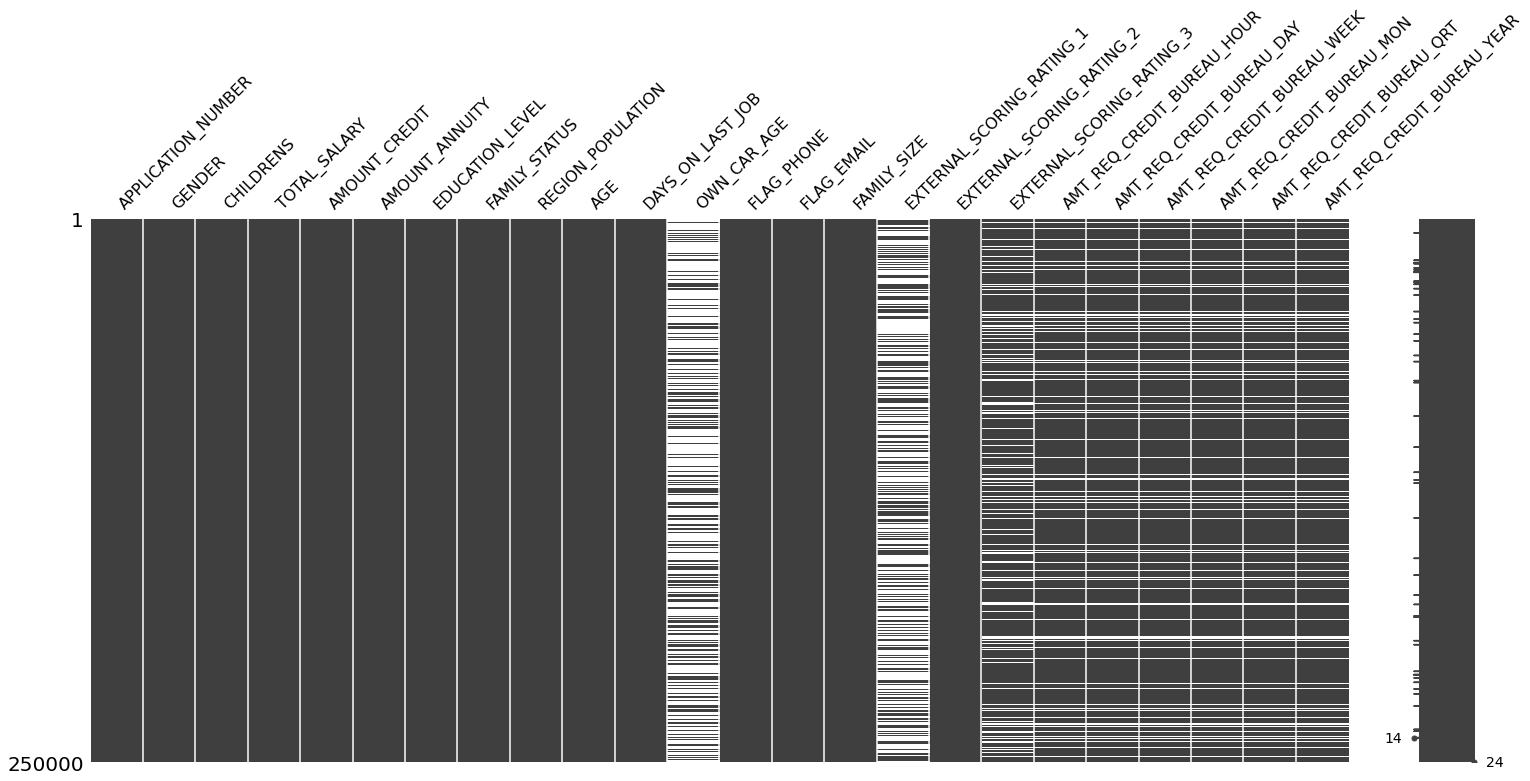

In [23]:
msno.matrix(client_profile);

In [24]:
client_profile.duplicated(subset=['APPLICATION_NUMBER']).value_counts()

False    250000
dtype: int64

**Нет дублей**

### payments

In [25]:
print("payments.shape = {} rows, {} cols".format(*payments.shape))
payments.head()

payments.shape = 1023932 rows, 8 cols


PREV_APPLICATION_NUMBER  APPLICATION_NUMBER  NUM_INSTALMENT_VERSION  \
0                 49011181           123664960                     1.0   
1                 48683432           123497205                     1.0   
2                 48652024           123749925                     1.0   
3                 48398897           123550846                     0.0   
4                 49867197           123562174                     0.0   

   NUM_INSTALMENT_NUMBER  DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  AMT_INSTALMENT  \
0                      5           1002.0              1015.0       12156.615   
1                     13            442.0               432.0       18392.535   
2                     10              8.0                23.0        5499.945   
3                     82            398.0               398.0        7082.145   
4                     63           1359.0              1359.0         156.735   

   AMT_PAYMENT  
0    12156.615  
1    10047.645  
2     5499.945  
3     7082.145  
4      156.735

In [26]:
payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1023932 entries, 0 to 1023931
Data columns (total 8 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   PREV_APPLICATION_NUMBER  1023932 non-null  int64  
 1   APPLICATION_NUMBER       1023932 non-null  int64  
 2   NUM_INSTALMENT_VERSION   1023932 non-null  float64
 3   NUM_INSTALMENT_NUMBER    1023932 non-null  int64  
 4   DAYS_INSTALMENT          1023932 non-null  float64
 5   DAYS_ENTRY_PAYMENT       1023729 non-null  float64
 6   AMT_INSTALMENT           1023932 non-null  float64
 7   AMT_PAYMENT              1023729 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 62.5 MB


In [27]:
payments.duplicated(subset=['APPLICATION_NUMBER']).value_counts()

True     759206
False    264726
dtype: int64

**Все признаки числовые, категориальных нет. 759206 дубликатов**

**Только признаки `DAYS_ENTRY_PAYMENT` и `AMT_PAYMENT` имеют по 203 пропуска каждый. Остальные признаки пропусков не имеют**

### applications_history

In [28]:
print("applications_history.shape = {} rows, {} cols".format(*applications_history.shape))
applications_history.head()

applications_history.shape = 1670214 rows, 26 cols


PREV_APPLICATION_NUMBER  APPLICATION_NUMBER NAME_CONTRACT_TYPE  \
0                 49298709           123595216                NaN   
1                 50070639           123431468               Cash   
2                 49791680           123445379               Cash   
3                 50087457           123499497               Cash   
4                 49052479           123525393               Cash   

   AMOUNT_ANNUITY  AMT_APPLICATION  AMOUNT_CREDIT  AMOUNT_PAYMENT  \
0        1730.430          17145.0        17145.0             0.0   
1       25188.615         607500.0       679671.0             NaN   
2       15060.735         112500.0       136444.5             NaN   
3       47041.335         450000.0       470790.0             NaN   
4       31924.395         337500.0       404055.0             NaN   

   AMOUNT_GOODS_PAYMENT NAME_CONTRACT_STATUS  DAYS_DECISION  ...  \
0               17145.0             Approved             73  ...   
1              607500.0             Approved            164  ...   
2              112500.0             Approved            301  ...   
3              450000.0             Approved            512  ...   
4              337500.0              Refused            781  ...   

  NAME_PRODUCT_TYPE SELLERPLACE_AREA CNT_PAYMENT NAME_YIELD_GROUP  \
0               XNA               35        12.0           middle   
1            x-sell               -1        36.0       low_action   
2            x-sell               -1        12.0             high   
3            x-sell               -1        12.0           middle   
4           walk-in               -1        24.0             high   

  DAYS_FIRST_DRAWING DAYS_FIRST_DUE DAYS_LAST_DUE_1ST_VERSION  DAYS_LAST_DUE  \
0           365243.0           42.0                     300.0           42.0   
1           365243.0          134.0                     916.0       365243.0   
2           365243.0          271.0                      59.0       365243.0   
3           365243.0          482.0                     152.0          182.0   
4                NaN            NaN                       NaN            NaN   

   DAYS_TERMINATION NFLAG_INSURED_ON_APPROVAL  
0              37.0                       0.0  
1          365243.0                       1.0  
2          365243.0                       1.0  
3             177.0                       1.0  
4               NaN                       NaN  

[5 rows x 26 columns]

In [29]:
applications_history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 26 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   PREV_APPLICATION_NUMBER    1670214 non-null  int64  
 1   APPLICATION_NUMBER         1670214 non-null  int64  
 2   NAME_CONTRACT_TYPE         940717 non-null   object 
 3   AMOUNT_ANNUITY             1297979 non-null  float64
 4   AMT_APPLICATION            1670214 non-null  float64
 5   AMOUNT_CREDIT              1670213 non-null  float64
 6   AMOUNT_PAYMENT             774370 non-null   float64
 7   AMOUNT_GOODS_PAYMENT       1284699 non-null  float64
 8   NAME_CONTRACT_STATUS       1670214 non-null  object 
 9   DAYS_DECISION              1670214 non-null  int64  
 10  NAME_PAYMENT_TYPE          1670214 non-null  object 
 11  CODE_REJECT_REASON         1670214 non-null  object 
 12  NAME_TYPE_SUITE            849809 non-null   object 
 13  NAME_CLIENT_

In [78]:
def clean_input(data) -> pd.DataFrame:
    """
    Перевод названий колонок в нижний регистр и вывод основной информации о наборе данных

    Parameters
    ----------
    data: Pandas DataFrame

    Returns
    -------
    data: pandas.core.frame.DataFrame
        Загруженный набор данных в pandas.DataFrame

    """
    #base_path = "data"
    #data = pd.read_csv(f"{base_path}/{data_path}")
    # Приводим все названия колонок к нижнему регистру
    data.columns = [col.lower() for col in data.columns]
    #print(f"{data_path}: shape = {data.shape[0]} rows, {data.shape[1]} cols")
    print(f"shape = {data.shape[0]} rows, {data.shape[1]} cols")

    return data


def get_num_features(df):
    """
    функция возвращает список числовых признаков
    :param df
    :return: list
    """
    numerical_features = df.select_dtypes(include=[np.number])
    # print(f"count of numeric_features_train {numerical_features.shape[1]}")
    return numerical_features.columns.to_list()


def get_cat_features(df):
    """
    функция возвращает список признаков с типом "объект"
    :param df:
    :return: list
    """
    categorical_features = df.select_dtypes(include=[np.object])
    return categorical_features.columns.to_list()

def label_encoder(X, categorical = None):
    estimators, encoders = [], {}
    if categorical:
        for feature in categorical:
            encoder = LabelEncoder()
            X[feature] = encoder.fit_transform(X[feature].astype("str").fillna("NA"))
            encoders[feature] = encoder
            
    return X

In [91]:
app_hist = clean_input(applications_history)

shape = 1670214 rows, 26 cols


In [92]:
app_hist_cat = get_cat_features(app_hist)
app_hist_cat

[]

In [82]:
app_hist_num = get_num_features(app_hist)
app_hist_num

['prev_application_number',
 'application_number',
 'amount_annuity',
 'amt_application',
 'amount_credit',
 'amount_payment',
 'amount_goods_payment',
 'days_decision',
 'sellerplace_area',
 'cnt_payment',
 'days_first_drawing',
 'days_first_due',
 'days_last_due_1st_version',
 'days_last_due',
 'days_termination',
 'nflag_insured_on_approval']

In [83]:
app_hist_coded = label_encoder(app_hist, categorical = app_hist_cat)
app_hist_coded.head()

prev_application_number  application_number  name_contract_type  \
0                 49298709           123595216                   2   
1                 50070639           123431468                   0   
2                 49791680           123445379                   0   
3                 50087457           123499497                   0   
4                 49052479           123525393                   0   

   amount_annuity  amt_application  amount_credit  amount_payment  \
0        1730.430          17145.0        17145.0             0.0   
1       25188.615         607500.0       679671.0             NaN   
2       15060.735         112500.0       136444.5             NaN   
3       47041.335         450000.0       470790.0             NaN   
4       31924.395         337500.0       404055.0             NaN   

   amount_goods_payment  name_contract_status  days_decision  ...  \
0               17145.0                     0             73  ...   
1              607500.0                     0            164  ...   
2              112500.0                     0            301  ...   
3              450000.0                     0            512  ...   
4              337500.0                     2            781  ...   

   name_product_type  sellerplace_area  cnt_payment  name_yield_group  \
0                  0                35         12.0                 4   
1                  2                -1         36.0                 2   
2                  2                -1         12.0                 1   
3                  2                -1         12.0                 4   
4                  1                -1         24.0                 1   

   days_first_drawing  days_first_due  days_last_due_1st_version  \
0            365243.0            42.0                      300.0   
1            365243.0           134.0                      916.0   
2            365243.0           271.0                       59.0   
3            365243.0           482.0                      152.0   
4                 NaN             NaN                        NaN   

   days_last_due  days_termination  nflag_insured_on_approval  
0           42.0              37.0                        0.0  
1       365243.0          365243.0                        1.0  
2       365243.0          365243.0                        1.0  
3          182.0             177.0                        1.0  
4            NaN               NaN                        NaN  

[5 rows x 26 columns]

In [85]:
# Для категориальных признаков, функция принимает сырые данные и считать
# количество и среднее значение наблюдений для каждого значения категории
# по категориальным признакам.

def create_categorical_aggs(data: pd.DataFrame,
                            groupby_id: str,
                            features: List[str],
                            prefix: Optional[str] = None,
                            suffix: Optional[str] = None,
                            ) -> pd.DataFrame:
    """
    Построение агрегаций для категориальных признаков.
    Для категориальных признако считаются счетчики для
    каждого значения категории и среднее значение счетчика
    для каждого значения категории.

    Parameters
    ----------
    data: pandas.core.frame.DataFrame
        Выборка для построения агрегаций.

    groupby_id: str
        Название ключа, по которому нужно произвести группировку.

    features: List[str]
        Список с названием признаков, для которых произвести
        группировку.

    prefix: str, optional, default = None
        Префикс для названия признаков.
        Опциональный параметр, по умолчанию, не используется.

    suffix: str, optional, default = None
        Суффикс для названия признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    stats: pandas.core.frame.DataFrame
        Выборка с рассчитанными агрегациями.

    """
    if not prefix:
        prefix = ""
    if not suffix:
        suffix = ""

    categorical = pd.get_dummies(data[features])
    columns_to_agg = categorical.columns

    categorical[groupby_id] = data[groupby_id]
    data_grouped = categorical.groupby(groupby_id)
    stats = data_grouped.agg({col: ["mean", "sum", "count"] for col in columns_to_agg})
    stats.columns = [f"{prefix}{feature}_{stat}{suffix}".upper() for feature, stat in stats]
    stats.columns = [col.replace("MEAN", "RATIO") for col in stats.columns]
    stats.columns = [col.replace("SUM", "TOTAL") for col in stats.columns]
    stats = stats.reset_index()

    return stats

app_hist_cat_agg = create_categorical_aggs(app_hist_coded,
                            groupby_id='application_number',
                            features=['prev_application_number', 'amount_credit'],
                            )
round(app_hist_cat_agg, 1)

application_number  PREV_APPLICATION_NUMBER_RATIO  \
0                123423340                     48637907.0   
1                123423341                     48307032.0   
2                123423342                     49549364.3   
3                123423343                     48832228.0   
4                123423344                     49445051.0   
...                    ...                            ...   
338852           123779590                     49516231.0   
338853           123779591                     48771813.0   
338854           123779592                     48945435.0   
338855           123779593                     49172872.5   
338856           123779594                     49108266.6   

        PREV_APPLICATION_NUMBER_TOTAL  PREV_APPLICATION_NUMBER_COUNT  \
0                            48637907                              1   
1                            48307032                              1   
2                           148648093                              3   
3                            48832228                              1   
4                            98890102                              2   
...                               ...                            ...   
338852                       49516231                              1   
338853                       48771813                              1   
338854                       97890870                              2   
338855                       98345745                              2   
338856                      392866133                              8   

        AMOUNT_CREDIT_RATIO  AMOUNT_CREDIT_TOTAL  AMOUNT_CREDIT_COUNT  
0                   23787.0              23787.0                    1  
1                  179055.0             179055.0                    1  
2                  484191.0            1452573.0                    3  
3                   20106.0              20106.0                    1  
4                   20076.8              40153.5                    2  
...                     ...                  ...                  ...  
338852              40455.0              40455.0                    1  
338853              56821.5              56821.5                    1  
338854              20625.8              41251.5                    2  
338855             134439.8             268879.5                    2  
338856             424431.0            3395448.0                    8  

[338857 rows x 7 columns]

In [89]:
def create_numerical_aggs(data: pd.DataFrame,
                          groupby_id: str,
                          aggs: dict,
                          prefix: Optional[str] = None,
                          suffix: Optional[str] = None,
                          ) -> pd.DataFrame:
    """
    Построение агрегаций для числовых признаков.

    Parameters
    ----------
    data: pandas.core.frame.DataFrame
        Выборка для построения агрегаций.

    groupby_id: str
        Название ключа, по которому нужно произвести группировку.

    aggs: dict
        Словарь с названием признака и списка функций.
        Ключ словаря - название признака, который используется для
        вычисления агрегаций, значение словаря - список с названием
        функций для вычисления агрегаций.

    prefix: str, optional, default = None
        Префикс для названия признаков.
        Опциональный параметр, по умолчанию, не используется.

    suffix: str, optional, default = None
        Суффикс для названия признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    stats: pandas.core.frame.DataFrame
        Выборка с рассчитанными агрегациями.

    """
    if not prefix:
        prefix = ""
    if not suffix:
        suffix = ""

    data_grouped = data.groupby(groupby_id)
    stats = data_grouped.agg(aggs)
    stats.columns = [f"{prefix}{feature}_{stat}{suffix}".upper() for feature, stat in stats]
    stats = stats.reset_index()

    return stats

app_hist_num_agg = create_numerical_aggs(app_hist_coded,
                            groupby_id='application_number',
                            aggs={'name_yield_group': ['sum', 'count']},
                            )
app_hist_num_agg['mean_int_rate'] = app_hist_num_agg['NAME_YIELD_GROUP_SUM'] / app_hist_num_agg['NAME_YIELD_GROUP_COUNT']
round(app_hist_num_agg, 1)

application_number  NAME_YIELD_GROUP_SUM  NAME_YIELD_GROUP_COUNT  \
0                123423340                     1                       1   
1                123423341                     3                       1   
2                123423342                    11                       3   
3                123423343                     4                       1   
4                123423344                     1                       2   
...                    ...                   ...                     ...   
338852           123779590                     1                       1   
338853           123779591                     3                       1   
338854           123779592                     2                       2   
338855           123779593                     4                       2   
338856           123779594                    20                       8   

        mean_int_rate  
0                 1.0  
1                 3.0  
2                 3.7  
3                 4.0  
4                 0.5  
...               ...  
338852            1.0  
338853            3.0  
338854            1.0  
338855            2.0  
338856            2.5  

[338857 rows x 4 columns]

In [66]:
round(statistic.describe(), 1)

APPLICATION_NUMBER  PREV_APPLICATION_NUMBER_RATIO  \
count            338857.0                       338857.0   
mean          123601488.9                     49184603.8   
std              102879.2                       332890.6   
min           123423340.0                     48268219.0   
25%           123512400.0                     48990584.3   
50%           123601560.0                     49187911.2   
75%           123690641.0                     49379807.3   
max           123779594.0                     50111975.0   

       PREV_APPLICATION_NUMBER_TOTAL  PREV_APPLICATION_NUMBER_COUNT  
count                   3.388570e+05                       338857.0  
mean                    2.424622e+08                            4.9  
std                     2.076768e+08                            4.2  
min                     4.826822e+07                            1.0  
25%                     9.827970e+07                            2.0  
50%                     1.960620e+08                            4.0  
75%                     3.422159e+08                            7.0  
max                     3.782110e+09                           77.0

In [46]:
round(applications_history.describe(), 1)

PREV_APPLICATION_NUMBER  APPLICATION_NUMBER  AMOUNT_ANNUITY  \
count                1670214.0           1670214.0       1297979.0   
mean                49191303.1         123601696.2         15955.1   
std                   532598.0            102814.8         14782.1   
min                 48268215.0         123423340.0             0.0   
25%                 48730071.2         123512668.0          6321.8   
50%                 49191324.5         123602053.5         11250.0   
75%                 49652493.8         123690853.0         20658.4   
max                 50113596.0         123779594.0        418058.1   

       AMT_APPLICATION  AMOUNT_CREDIT  AMOUNT_PAYMENT  AMOUNT_GOODS_PAYMENT  \
count        1670214.0      1670213.0        774370.0             1284699.0   
mean          175233.9       196114.0          6697.4              227847.3   
std           292779.8       318574.6         20921.5              315396.6   
min                0.0            0.0            -0.9                   0.0   
25%            18720.0        24160.5             0.0               50841.0   
50%            71046.0        80541.0          1638.0              112320.0   
75%           180360.0       216418.5          7740.0              234000.0   
max          6905160.0      6905160.0       3060045.0             6905160.0   

       DAYS_DECISION  SELLERPLACE_AREA  CNT_PAYMENT  DAYS_FIRST_DRAWING  \
count      1670214.0         1670214.0    1297984.0            997149.0   
mean           880.7             314.0         16.1            342340.1   
std            779.1            7127.4         14.6             88413.5   
min              1.0              -1.0          0.0                 2.0   
25%            280.0              -1.0          6.0            365243.0   
50%            581.0               3.0         12.0            365243.0   
75%           1300.0              82.0         24.0            365243.0   
max           2922.0         4000000.0         84.0            365243.0   

       DAYS_FIRST_DUE  DAYS_LAST_DUE_1ST_VERSION  DAYS_LAST_DUE  \
count        997149.0                   997149.0       997149.0   
mean          15949.2                    35163.4        78152.7   
std           72007.3                   106406.0       148833.3   
min               2.0                        0.0            2.0   
25%             475.0                      257.0          455.0   
50%             921.0                      741.0         1155.0   
75%            1825.0                     1735.0         2418.0   
max          365243.0                   365243.0       365243.0   

       DAYS_TERMINATION  NFLAG_INSURED_ON_APPROVAL  
count          997149.0                   997149.0  
mean            83505.8                        0.3  
std            152484.4                        0.5  
min                 2.0                        0.0  
25%               447.0                        0.0  
50%              1171.0                        0.0  
75%              2501.0                        1.0  
max            365243.0                        1.0

In [30]:
# получим список признаков с категорией object
applications_history_obj_feat = list(applications_history.loc[:, applications_history.dtypes == 'object'].columns.values)
applications_history_obj_feat, len(applications_history_obj_feat)

(['NAME_CONTRACT_TYPE',
  'NAME_CONTRACT_STATUS',
  'NAME_PAYMENT_TYPE',
  'CODE_REJECT_REASON',
  'NAME_TYPE_SUITE',
  'NAME_CLIENT_TYPE',
  'NAME_GOODS_CATEGORY',
  'NAME_PORTFOLIO',
  'NAME_PRODUCT_TYPE',
  'NAME_YIELD_GROUP'],
 10)

In [31]:
# список уникальных значений по категориальным фичам
for column in applications_history_obj_feat:
    print(f'{column}: {applications_history[column].unique()} \n')

NAME_CONTRACT_TYPE: [nan 'Cash' 'Credit Card'] 

NAME_CONTRACT_STATUS: ['Approved' 'Refused' 'Canceled' 'Unused offer'] 

NAME_PAYMENT_TYPE: ['Cash through the bank' 'XNA' 'Non-cash from your account'
 'Cashless from the account of the employer'] 

CODE_REJECT_REASON: ['XAP' 'HC' 'LIMIT' 'CLIENT' 'SCOFR' 'SCO' 'XNA' 'VERIF' 'SYSTEM'] 

NAME_TYPE_SUITE: [nan 'Unaccompanied' 'Spouse, partner' 'Family' 'Children' 'Other_B'
 'Other_A' 'Group of people'] 

NAME_CLIENT_TYPE: ['Repeater' 'New' 'Refreshed' 'XNA'] 

NAME_GOODS_CATEGORY: ['Mobile' 'XNA' 'Consumer Electronics' 'Construction Materials'
 'Auto Accessories' 'Photo / Cinema Equipment' 'Computers' 'Audio/Video'
 'Medicine' 'Clothing and Accessories' 'Furniture' 'Sport and Leisure'
 'Homewares' 'Gardening' 'Jewelry' 'Vehicles' 'Education'
 'Medical Supplies' 'Other' 'Direct Sales' 'Office Appliances' 'Fitness'
 'Tourism' 'Insurance' 'Additional Service' 'Weapon' 'Animals'
 'House Construction'] 

NAME_PORTFOLIO: ['POS' 'Cash' 'XNA' 'Ca

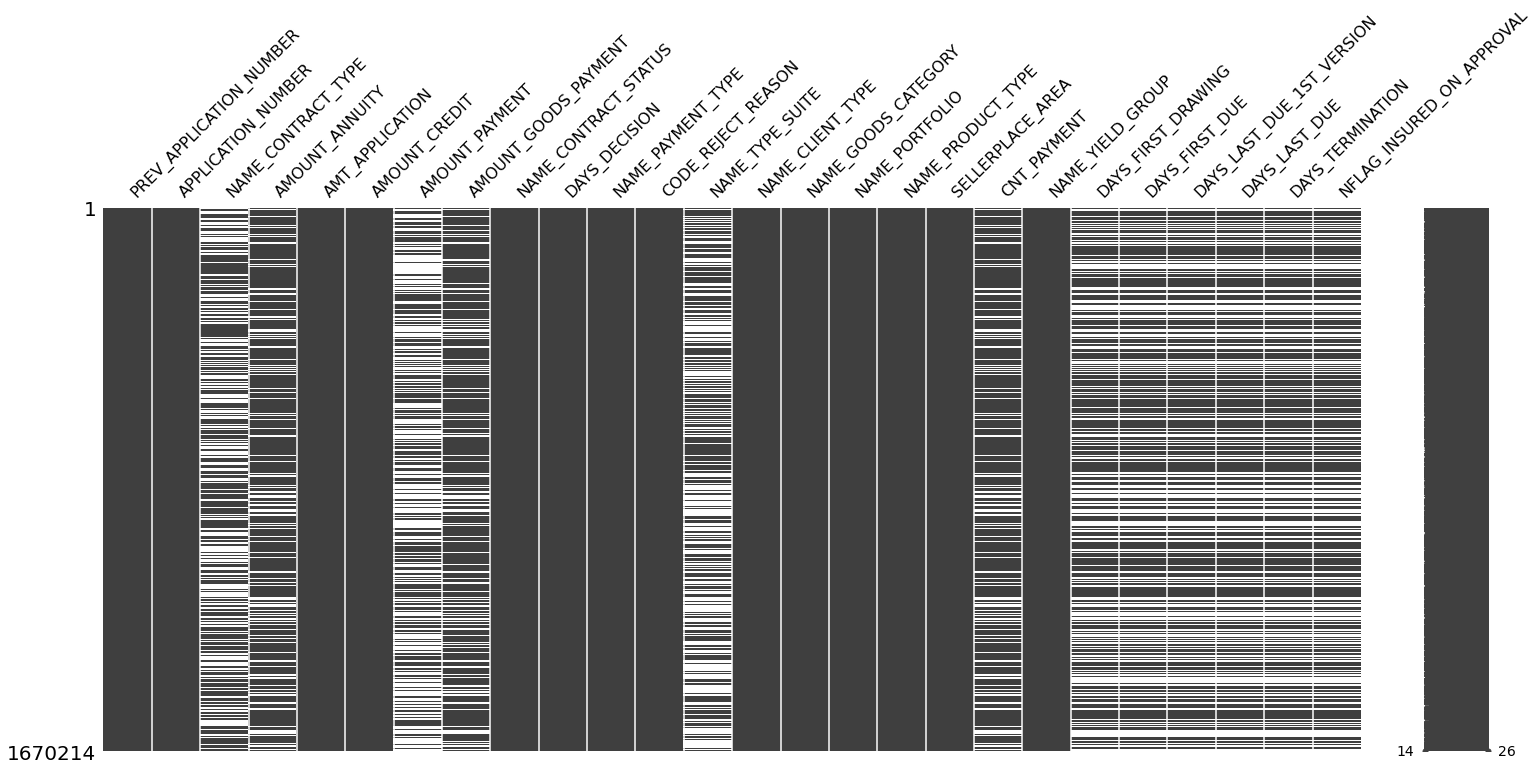

In [32]:
msno.matrix(applications_history);

In [33]:
applications_history.duplicated(subset=['APPLICATION_NUMBER']).value_counts()

True     1331357
False     338857
dtype: int64

**applications_history имеет 1331357 повторяющихся значений по 'APPLICATION_NUMBER'. Надо подумать как сконкатенировать**

### Целевая переменная

In [34]:
train['TARGET'].unique()

array([0, 1], dtype=int64)

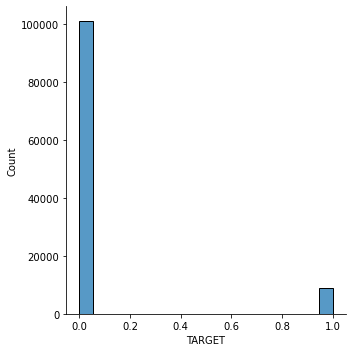

In [35]:
sns.displot(train, x='TARGET');


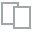
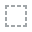
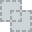
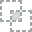
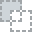
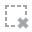
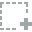
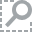
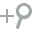
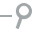
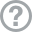
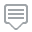
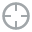
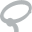
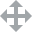
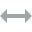
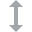
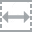
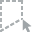
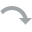
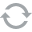
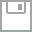
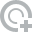
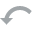
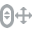
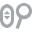
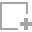
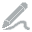
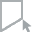
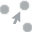
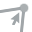
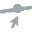

In [37]:
plot(train)


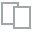
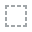
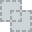
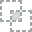
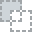
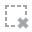
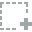
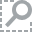
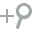
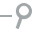
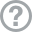
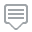
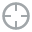
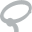
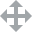
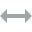
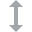
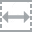
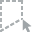
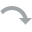
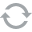
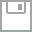
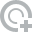
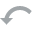
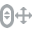
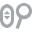
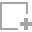
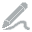
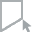
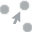
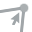
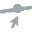

In [38]:
plot(bki)


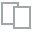
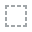
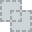
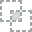
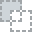
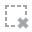
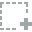
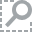
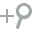
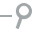
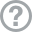
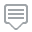
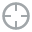
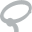
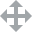
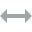
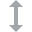
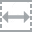
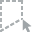
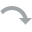
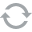
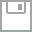
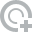
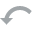
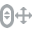
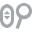
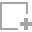
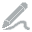
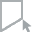
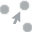
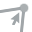
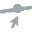

In [39]:
plot(client_profile)

In [43]:
#plot(payments)


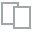
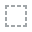
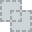
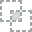
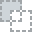
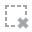
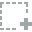
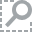
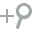
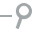
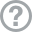
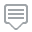
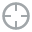
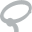
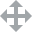
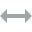
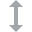
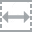
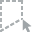
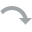
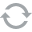
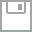
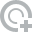
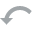
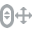
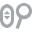
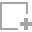
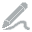
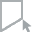
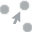
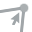
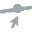

In [41]:
plot(applications_history)